<a href="https://colab.research.google.com/github/Kalvaabhi/AIML/blob/main/NNFL_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50
 accuracy: 0.9553 - loss: 0.3440
Epoch 2/50
 accuracy: 0.9553 - loss: 0.3626
Epoch 3/50
 accuracy: 0.9553 - loss: 0.3038
Epoch 4/50
 accuracy: 0.9553 - loss: 0.2916
Epoch 5/50
 accuracy: 0.9553 - loss: 0.2334
Epoch 6/50
 accuracy: 0.9553 - loss: 0.3788
Epoch 7/50
 accuracy: 0.9553 - loss: 0.2290
Epoch 8/50
 accuracy: 0.9547 - loss: 0.3215
Epoch 9/50
 accuracy: 0.9555 - loss: 0.3066
Epoch 10/50
 accuracy: 0.9553 - loss: 0.2889
Epoch 11/50
 accuracy: 0.9553 - loss: 0.3514
Epoch 12/50
 accuracy: 0.9553 - loss: 0.3353
Epoch 13/50
 accuracy: 0.9544 - loss: 0.2531
Epoch 14/50
 accuracy: 0.9553 - loss: 0.2264
Epoch 15/50
 accuracy: 0.9553 - loss: 0.2680
Epoch 16/50
 accuracy: 0.0447 - loss: 1.9770
Epoch 17/50
 accuracy: 0.9553 - loss: 0.2664
Epoch 18/50
 accuracy: 0.9553 - loss: 0.3304
Epoch 19/50
 accuracy: 0.0447 - loss: 2.0592
Epoch 20/50
 accuracy: 0.9553 - loss: 0.3270
Epoch 21/50
 accuracy: 0.9553 - loss: 0.2586
Epoch 22/50
 accuracy: 0.9553 - loss: 0.3203
Epoch 23/50
 accura

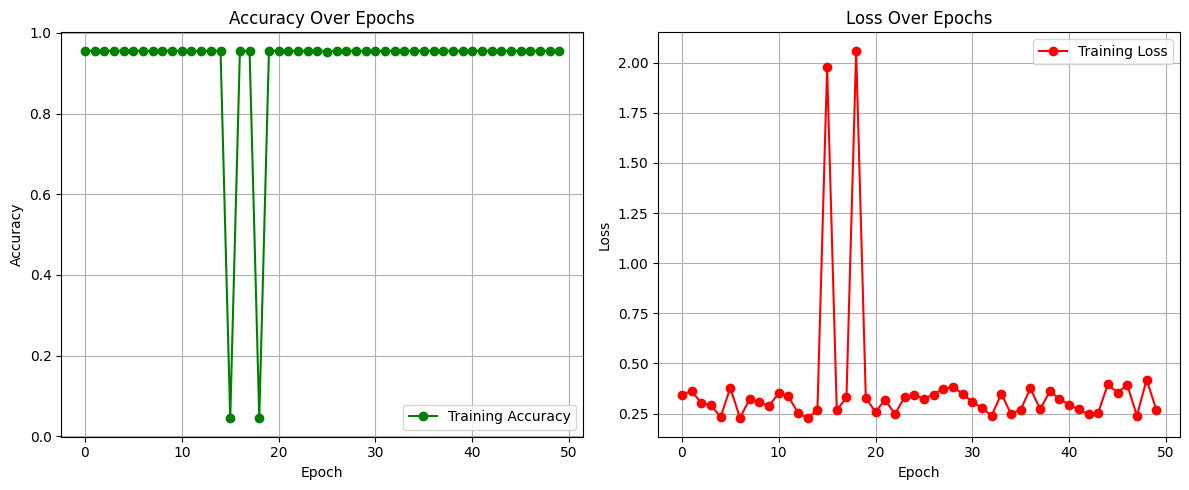

In [ ]:
# ===============================================
# 1. Import and Load Data
# ===============================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset (upload manually in Colab)
df = pd.read_csv("/content/healthcare-dataset-stroke-data.csv")

# ===============================================
# 2. Preprocess Data
# ===============================================
df.drop("id", axis=1, inplace=True)
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

X = df.drop("stroke", axis=1).values
y = df["stroke"].values.reshape(-1, 1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ===============================================
# 3. ANN Functions using NumPy
# ===============================================
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def forward_propagation(X, weights):
    w1, b1, w2, b2 = weights['w1'], weights['b1'], weights['w2'], weights['b2']
    z1 = np.dot(X, w1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, w2) + b2
    a2 = sigmoid(z2)
    return a2

def compute_accuracy(y_true, y_pred):
    return np.mean((y_pred > 0.5) == y_true)

def unpack_weights(flat_weights, input_dim, hidden_dim, output_dim):
    w1_end = input_dim * hidden_dim
    b1_end = w1_end + hidden_dim
    w2_end = b1_end + hidden_dim * output_dim
    w1 = flat_weights[:w1_end].reshape(input_dim, hidden_dim)
    b1 = flat_weights[w1_end:b1_end].reshape(1, hidden_dim)
    w2 = flat_weights[b1_end:w2_end].reshape(hidden_dim, output_dim)
    b2 = flat_weights[w2_end:].reshape(1, output_dim)
    return {'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2}

def fitness(flat_weights, input_dim, hidden_dim, output_dim, X, y):
    weights = unpack_weights(flat_weights, input_dim, hidden_dim, output_dim)
    y_pred = forward_propagation(X, weights)
    return compute_accuracy(y, y_pred)

# ===============================================
# 4. Hill Climbing Optimizer
# ===============================================
def generate_neighbours(sol, step_size):
    return [sol + np.eye(len(sol))[i] * d * step_size
            for i in range(len(sol)) for d in [-1, 1]]

def hill_climbing_optimize(fitness_fn, initial_sol, step_size=0.1, max_iter=100):
    best_sol = initial_sol.copy()
    best_score = fitness_fn(best_sol)

    for _ in range(max_iter):
        neighbours = generate_neighbours(best_sol, step_size)
        improvement = False
        for neighbour in neighbours:
            score = fitness_fn(neighbour)
            if score > best_score:
                best_sol = neighbour
                best_score = score
                improvement = True
        if not improvement:
            break
    return best_sol, best_score

# ===============================================
# 5. Train ANN with Hill Climbing (50 Epochs + Graph Tracking)
# ===============================================
import matplotlib.pyplot as plt

input_dim = X_train.shape[1]
hidden_dim = 10
output_dim = 1
total_weights = input_dim * hidden_dim + hidden_dim + hidden_dim * output_dim + output_dim

np.random.seed(42)
best_overall_weights = None
best_overall_acc = 0

accuracy_history = []
loss_history = []

for epoch in range(50):
    print(f"Epoch {epoch + 1}/50")

    # Initialize weights randomly
    initial_weights = np.random.uniform(-1, 1, total_weights)

    # Define fitness function
    fitness_fn = lambda w: fitness(w, input_dim, hidden_dim, output_dim, X_train, y_train)

    # Run Hill Climbing
    best_weights, train_acc = hill_climbing_optimize(fitness_fn, initial_weights, step_size=0.1, max_iter=100)

    # Compute predictions and loss
    weights_dict = unpack_weights(best_weights, input_dim, hidden_dim, output_dim)
    y_pred_train = forward_propagation(X_train, weights_dict)
    loss = compute_loss(y_train, y_pred_train)

    # Save to history
    accuracy_history.append(train_acc)
    loss_history.append(loss)

    # Print per epoch
    print(f" accuracy: {train_acc:.4f} - loss: {loss:.4f}")

    # Keep best weights
    if train_acc > best_overall_acc:
        best_overall_acc = train_acc
        best_overall_weights = best_weights

# ===============================================
# 6. Final Evaluation + Graphs
# ===============================================
final_weights = unpack_weights(best_overall_weights, input_dim, hidden_dim, output_dim)
y_pred_test = forward_propagation(X_test, final_weights)
test_acc = compute_accuracy(y_test, y_pred_test)

print("\n✅ Best Training Accuracy:", best_overall_acc)
print("✅ Test Accuracy:", test_acc)

# Plotting
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(accuracy_history, marker='o', label='Training Accuracy', color='green')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(loss_history, marker='o', label='Training Loss', color='red')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()